# Kinematic Arm Simulation
This Jupyter Notebook simulates a kinematic arm using inverse kinematics. The arm dynamically adjusts its link lengths and the number of joints can be controlled with a slider.

You can:
- Adjust the number of joints with a slider.
- Click anywhere on the plot to move the target.
- Watch the arm attempt to reach the target using inverse kinematics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

# Kinematic Arm Simulation Parameters
link_lengths = [2, 2]
num_links = len(link_lengths)

# State flags
reached_target = False
movement_count = 0

## Defining the Functions
The following functions define the forward kinematics, link optimization, and inverse kinematics for the arm simulation.

In [2]:
def forward_kinematics(angles):
    x, y = [0], [0]
    for i in range(num_links):
        x.append(x[-1] + link_lengths[i] * np.cos(np.sum(angles[:i+1])))
        y.append(y[-1] + link_lengths[i] * np.sin(np.sum(angles[:i+1])))
    return x, y

def optimize_link_lengths(target, angles):
    total_distance = np.linalg.norm(target)
    link_length = total_distance / num_links
    return [link_length] * num_links

def inverse_kinematics(target, angles, alpha=0.1, max_iters=100):
    global link_lengths, reached_target
    if target is None:
        return angles
    link_lengths = optimize_link_lengths(target, angles)
    for _ in range(max_iters):
        x, y = forward_kinematics(angles)
        end_effector = np.array([x[-1], y[-1]])
        error = target - end_effector
        if np.linalg.norm(error) < 1e-1:
            reached_target = True
            break
        reached_target = False
        for i in range(num_links):
            angles_temp = angles.copy()
            angles_temp[i] += 0.01
            x_temp, y_temp = forward_kinematics(angles_temp)
            end_effector_temp = np.array([x_temp[-1], y_temp[-1]])
            gradient = (np.linalg.norm(end_effector_temp - target) - np.linalg.norm(error)) / 0.01
            angles[i] -= alpha * gradient
    return angles

## Visualization Setup
This section sets up the Matplotlib plot and the animation parameters, including the interactive slider and the click event for target movement.

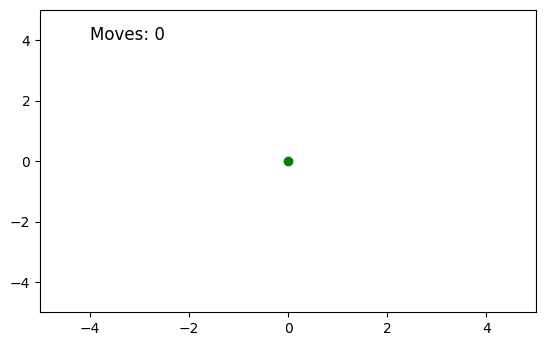

In [3]:
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
line, = ax.plot([], [], 'o-', lw=2)
target_dot, = ax.plot([], [], 'ro')
base_dot, = ax.plot([0], [0], 'go')
movement_text = ax.text(-4, 4, 'Moves: 0', fontsize=12)
angles = np.radians([45, 45])
target = np.array([3, 1])

## Interactive Controls
This slider allows you to change the number of joints in the simulation dynamically.

0

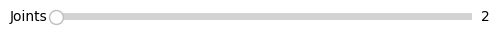

In [4]:
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03])
slider = Slider(ax_slider, 'Joints', 2, 5, valinit=num_links, valstep=1)

def update_num_links(val):
    global num_links, link_lengths, angles, target, reached_target, movement_count
    num_links = int(val)
    link_lengths = [2] * num_links
    angles = np.radians([45] * num_links)
    target = np.array([3, 1])
    reached_target = False
    movement_count = 0
    update(0)

slider.on_changed(update_num_links)

## Animation and Interaction
This section handles the animation, including updating the arm's position and responding to mouse clicks to move the target.

In [5]:
def update(frame):
    global angles, reached_target, movement_count
    if not reached_target:
        angles = inverse_kinematics(target, angles)
        movement_count += 1
    x, y = forward_kinematics(angles)
    line.set_data(x, y)
    target_dot.set_data([target[0]], [target[1]])
    base_dot.set_data([0], [0])
    movement_text.set_text(f'Moves: {movement_count}')
    return line, target_dot, base_dot, movement_text

def on_click(event):
    global target, reached_target, movement_count
    if event.xdata is not None and event.ydata is not None:
        target = np.array([event.xdata, event.ydata])
        reached_target = False
        movement_count = 0

fig.canvas.mpl_connect('button_press_event', on_click)
ani = FuncAnimation(fig, update, frames=100, blit=True)
plt.show()